In [167]:
import numpy as np
import math 
# from sympy import *
# from sympy.abc import x,y,X,Y
import random
# import operator
# import sys
import pandas as pd
# import pickle
import plotly.express as px
# %load_ext memory_profiler
# from sympy import Symbol 
# from sympy import MatrixSymbol, Matrix
# from collections import deque
# PRECISION = 6
# from multiprocessing import Pool
# from functools import partial
import tqdm
# import time
import string
# import json
from matplotlib import pyplot as plt

In [168]:
def choose(n, k):
    if 0 <= k <= n:
        ntok = 1
        ktok = 1
        for t in range(1, min(k, n - k) + 1):
            ntok *= n
            ktok *= t
            n -= 1
        return ntok // ktok
    else:
        return 0

## Bernoulli random variable 

In [169]:
# 1 denotes erasure and 0 denotes no erasure
def brv(p):
    tkn = np.random.uniform(0,1)
    if tkn <= p :
        return "1"
    else :
        return "0"

## Realizaton of a Gilbert-Elliot Channel 

In [170]:
# Let the markov chain initially be in good state
def mc_ge(a,b,e1,e2,TIME):
    rls = "g"
    ers_ptn = brv(e1)
    
    for t in range(1,TIME):
        pv_st = rls[t-1]
        tkn = np.random.uniform(0,1)
        if pv_st == "g":
            if tkn <= 1-a:
                rls += "g"
                ers_ptn += brv(e1)
            else :
                rls += "b"
                ers_ptn += brv(e2)                                
        else:
            if tkn <= 1-b:
                rls += "b"
                ers_ptn += brv(e2)                
            else :
                rls += "g"
                ers_ptn += brv(e1)
    return rls,ers_ptn

In [82]:
a = 0.002
b = 0.5
e1 = 0.0001
e2 = 1
TIME = 100

rls,ers_ptn = mc_ge(a,b,e1,e2,TIME)
print("States: ",rls)
print("Erasure Pattern: ",ers_ptn)

States:  gggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggg
Erasure Pattern:  0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000


# AoI calulation - Simulation

In [83]:
# Number of Sources 
K = 200

# Note: Initially the channel is in good state!
gtob = 0.01
btog = 0.5
e1 = 0.00001
e2 = 1

# Round-Robin scheduling 
NUM_ROUNDS = 500
TIME = NUM_ROUNDS*K 

# Generating the erasure pattern and the channel realization
rls,ers_ptn = mc_ge(gtob,btog,e1,e2,TIME)

In [84]:
# ers_ptn

In [85]:
TIME

100000

## No Coding

In [86]:
# u: time-stamp and the latest recieved packet
u = {}
for k in range(K):
    u[k] = []  
for t in range(0,TIME):
    src = t%K 
    if ers_ptn[t] == "0":
        u[src].append((t,t+1))

In [87]:
# Instantaneous Age
delta = {}
for k in tqdm.tqdm(range(K)):
    time_stamps = [i[0] for i in u[k]]
    rec_packs = [i[1] for i in u[k]]
    delta[k] = []
    time = time_stamps[0]+1
    for i in range(1,len(time_stamps)):
        crn_time_stamp = time_stamps[i-1]
        fut_rec_pack = rec_packs[i]
        while (time<fut_rec_pack):
            delta[k].append((time,time-crn_time_stamp))
            time+= 1 

100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 41.64it/s]


In [88]:
# delta[0]

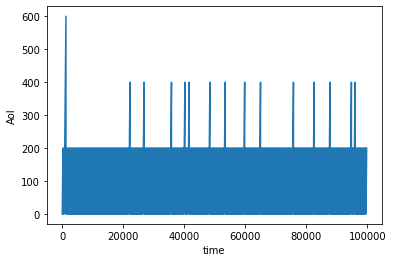

In [89]:
x = []
y = []
src = 0
for i in range(len(delta[src])):
    x.append(delta[src][i][0])
    y.append(delta[src][i][1])
plt.plot(x,y,"-")
plt.xlabel("time")
plt.ylabel("AoI")
plt.show()

In [90]:
AoI = {}
AoI_sys = 0
cnt = 0
for k in tqdm.tqdm(range(K)):
    if (delta[k]):
        cnt += 1 
        x = []
        y = []
        for i in range(len(delta[k])):
            x.append(delta[k][i][0])
            y.append(delta[k][i][1])
        AoI[k] = np.trapz(y,dx=1)/len(x)
        AoI_sys += AoI[k]
AoI_sys /= cnt

100%|█████████████████████████████████████████| 200/200 [00:06<00:00, 31.19it/s]


In [91]:
AoI_sys

104.55526111434716

In [92]:
# Analytical expression for qEC(e1)
# AoI_sys_th = (K/2)*((1+e1)/(1-e1)) + 1
# AoI_sys_th

## MDS Code 

In [134]:
n = 11
dim = 5

In [135]:
# # dim = 12
# n = 10
# # dim = math.floor(n - n*e1)-1
# dim = 6
R = dim/n
NUM_BLOCKS = (int) (TIME/n)
TIME = (n*NUM_BLOCKS)
BLOCK_FAILURE = np.zeros((NUM_BLOCKS))
NUM_BLOCK_ERS = 0 

for CRNT_BLOCK in range(NUM_BLOCKS):
    cnt = 1 
    ers_cnt = 0 
    while cnt<=n:
        t = CRNT_BLOCK*n + cnt-1
        if ers_ptn[t] =="1":
            ers_cnt +=1  
        cnt+=1         
    if ers_cnt > (n-dim):
        BLOCK_FAILURE[CRNT_BLOCK] = 1
        NUM_BLOCK_ERS +=1 

In [136]:
# NUM_BLOCKS

In [137]:
NUM_BLOCK_ERS/NUM_BLOCKS

0.00055005500550055

In [138]:
src = 0
cnt = 0
t = 0
trans = []
while t<TIME:
    cnt +=1 
    if src==K:
        src=0
    trans.append((t,src))
    if cnt==dim:
        cnt=0 
        t+=n-dim
    
    src+=1
    t+=1   

In [139]:
# u: time-stamp and the latest recieved packet
u = {}
for k in range(K):
    u[k] = []  
    
BLOCK_NUM = -1   
for t in trans:
    time = t[0]
    src = t[1]
    if time%n==0:
        BLOCK_NUM+=1
    POS_IN_BLOCK = time%n
    if ers_ptn[time] == "0":
        u[src].append((time,time+1))
    elif ers_ptn[time] == "1" and BLOCK_FAILURE[BLOCK_NUM] == 0:
        u[src].append((time,time+n-POS_IN_BLOCK))
        

In [140]:
# Instantaneous Age
delta = {}
for k in tqdm.tqdm(range(K)):
    time_stamps = [i[0] for i in u[k]]
    rec_packs = [i[1] for i in u[k]]
    delta[k] = []
    time = time_stamps[0]+1
    for i in range(1,len(time_stamps)):
        crn_time_stamp = time_stamps[i-1]
        fut_rec_pack = rec_packs[i]
        while (time<fut_rec_pack):
            delta[k].append((time,time-crn_time_stamp))
            time+= 1  

100%|█████████████████████████████████████████| 200/200 [00:05<00:00, 39.76it/s]


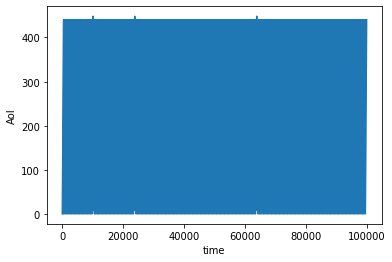

In [141]:
x = []
y = []
src = 22
for i in range(len(delta[src])):
    x.append(delta[src][i][0])
    y.append(delta[src][i][1])
plt.plot(x,y,"-")
plt.xlabel("time")
plt.ylabel("AoI")
plt.show()

In [142]:
AoI = {}
AoI_sys = 0
cnt = 0
for k in tqdm.tqdm(range(K)):
    if (delta[k]):
        cnt += 1 
        x = []
        y = []
        for i in range(len(delta[k])):
            x.append(delta[k][i][0])
            y.append(delta[k][i][1])
        AoI[k] = np.trapz(y,dx=1)/len(x)
        AoI_sys += AoI[k]
AoI_sys /= cnt

100%|█████████████████████████████████████████| 200/200 [00:06<00:00, 28.71it/s]


In [143]:
AoI_sys

220.80108801468847

In [144]:
# Analytical expression for qEC(e1)

# phi = 0
# for i in range(n-dim):
#     phi += choose(n-1,i)*(e1**i)*((1-e1)**(n-1-i))
# pf = 1 -((1-e1)+e1*phi)

# AoI_sys_th = (K/(2*R))*((1+pf)/(1-pf)) + (R/K)*(((1-e1)*(e1*phi)*((n-1)**2))/(1-pf))
# AoI_sys_th

In [145]:
# pf

## Streaming Codes 

In [151]:
T = 10 
a = 4
b = 7
n = T + 1 -a +b
dim = T+1-a

# n = T+1-a+b
# dim = T+1-a
# n = 10
# dim = 7
R = dim/n

# b = n-dim
# a = max(b,1)
# T = dim-1+a


NUM_BLOCKS = (int) (TIME/n)
TIME = n*NUM_BLOCKS
BLOCK_FAILURE = np.zeros((NUM_BLOCKS))
NUM_BLOCK_ERS = 0
for CRNT_BLOCK in range(NUM_BLOCKS):
    cnt = 1  
    ers_pos_block = []
    while cnt<=n:
        t = CRNT_BLOCK*n + cnt-1
        if ers_ptn[t] =="1":
            ers_pos_block.append(t)
        cnt+=1         
    rand_ers_cnt = len(ers_pos_block)
    if (rand_ers_cnt):
        ers_span = ers_pos_block[-1]-ers_pos_block[0]+1
        if (rand_ers_cnt > a) and (ers_span>b):
            BLOCK_FAILURE[CRNT_BLOCK] = 1
            NUM_BLOCK_ERS +=1 

In [152]:
(a,b,T)

(4, 7, 10)

In [153]:
R

0.5

In [154]:
NUM_BLOCK_ERS/NUM_BLOCKS

0.0015401848221786615

In [155]:
src = 0
cnt = 0
t = 0
trans = []
while t<TIME:
    cnt +=1 
    if src==K:
        src=0
    trans.append((t,src))
    if cnt==dim:
        cnt=0 
        t+=n-dim
    
    src+=1
    t+=1   

In [156]:
# trans[0:300]

In [157]:
# u: time-stamp and the latest recieved packet
u = {}
for k in range(K):
    u[k] = []  
    
BLOCK_NUM = -1   
for t in trans:
    time = t[0]
    src = t[1]
    if time%n==0:
        BLOCK_NUM+=1
    POS_IN_BLOCK = time%n
    if ers_ptn[time] == "0":
        u[src].append((time,time+1))
    elif ers_ptn[time] == "1" and BLOCK_FAILURE[BLOCK_NUM] == 0:
        u[src].append((time,time+(T+1)-POS_IN_BLOCK))

In [158]:
# Instantaneous Age
delta = {}
for k in tqdm.tqdm(range(K)):
    time_stamps = [i[0] for i in u[k]]
    rec_packs = [i[1] for i in u[k]]
    delta[k] = []
    time = time_stamps[0]+1
    for i in range(1,len(time_stamps)):
        crn_time_stamp = time_stamps[i-1]
        fut_rec_pack = rec_packs[i]
        while (time<fut_rec_pack):
            delta[k].append((time,time-crn_time_stamp))
            time+= 1  

100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 40.23it/s]


In [159]:
AoI = {}
AoI_sys = 0
cnt = 0
for k in tqdm.tqdm(range(K)):
    if (delta[k]):
        cnt += 1 
        x = []
        y = []
        for i in range(len(delta[k])):
            x.append(delta[k][i][0])
            y.append(delta[k][i][1])
        AoI[k] = np.trapz(y,dx=1)/len(x)
        AoI_sys += AoI[k]
AoI_sys /= cnt

100%|█████████████████████████████████████████| 200/200 [00:07<00:00, 27.93it/s]


In [160]:
AoI_sys

200.900719354573

# Analysis of Analytical expressions

In [171]:
K = 1000
e1 = 0.3
n = 10
dim = math.floor(n-n*e1+1)

In [172]:
AoI_sys_th_uncoded = []
pf_list = []
R_list = []
AoI_sys_th_coded = []
for dim in tqdm.tqdm(range(2,n+1)):
    R = dim/n
    phi = 0
    for i in range(n-dim):
        phi += choose(n-1,i)*(e1**i)*((1-e1)**(n-1-i))
    pf = 1 -((1-e1)+e1*phi)
    pf_list.append(pf)
    R_list.append(R)
    AoI_sys_th_coded.append((K/(2*R))*((1+pf)/(1-pf)))
    AoI_sys_th_uncoded.append((K/(2))*((1+e1)/(1-e1)))

100%|██████████████████████████████████████████| 9/9 [00:00<00:00, 58890.38it/s]


In [173]:
d = {"Rate":R_list, "Coded":AoI_sys_th_coded, "Uncoded":AoI_sys_th_uncoded}
Df = pd.DataFrame(data = d)

In [174]:
Df

,Rate,Coded,Uncoded
0,0.2,2500.649623,928.571429
1,0.3,1670.963091,928.571429
2,0.4,1269.116194,928.571429
3,0.5,1061.096248,928.571429
4,0.6,980.433981,928.571429
5,0.7,988.727382,928.571429
6,0.8,1022.335796,928.571429
7,0.9,1004.761284,928.571429
8,1.0,928.571429,928.571429


In [175]:
fig = px.line(Df, x="Rate", y=["Uncoded","Coded"], title='AoI')
fig.show()

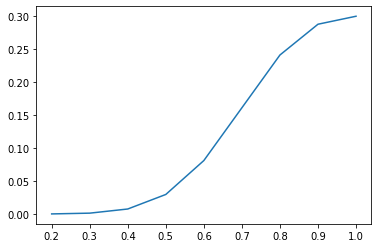

In [176]:
plt.plot(R_list,pf_list)